In [61]:
import seaborn as sns
import json
import pandas as pd
from numpy import average
import matplotlib.pyplot as plt
import os
plt.ioff()

### Setup

In [2]:
translate_b =  {"histogram":"Histogram", "merge_sort":"Merge Sort","lu_decomposition":"LU Decomposition",
    "quadrature":"Quadrature", "monte_carlo":"Monte Carlo","needleman_wunsch":"Needleman-Wunsch"}
benchmark_settings = {
    "histogram":{
        "sizes":["10000","50000","1000000","2500000","5000000","7500000","10000000"],
        "default_size":"5000000"
    },
    "merge_sort":{
        "sizes":["10000","50000","1000000","2500000","5000000","7500000","10000000"],        
         "default_size":"5000000"
    },
    "lu_decomposition":{
        "cpp":True,
        "sizes":["50", "100", "200", "400", "800"],
        "default_size":"400"
    },
    "quadrature":{
        "cpp":True,
        "sizes":["1000", "10000", "100000", "1000000"],   
        "default_size":"100000"
    },
    "monte_carlo":{
        "sizes":["10000","50000","1000000","2500000","5000000","7500000","10000000"], 
         "default_size":"5000000"  
    },
    "needleman_wunsch":{
        "math_lib":True,
        "needs_input_files": True,
        "extra_inputs": ["false"],
        "sizes":["500", "1000", "2500", "5000", "7500", "10000"],
        "default_size":"5000"
    },
}

In [3]:
def avg(l):
    return sum(l)/len(l)

In [4]:
with open("../saved_suite_history.json") as f:
    data = json.load(f)

### Dataframe constructors

In [11]:
def simple_construct_df(bench,metric_f):
    df = pd.DataFrame(columns=['metric_val', 'language',
                                'size',"threads"])

    bench_d = data[bench]
    i = 0
    for thread, t_d in bench_d["omp_run_stats"].items():
        for size, size_d in t_d.items():
            df.loc[i] = [avg(metric_f(size_d)),"OpenMP",size,thread]
            i += 1
    for thread, t_d in bench_d["rust_run_stats"].items():
        for size, size_d in t_d.items():
            df.loc[i] = [avg(metric_f(size_d)),"Rust",size,thread]
            i += 1
    return df

In [12]:
def speedup_construct_df(bench,metric_f):
    df = pd.DataFrame(columns=['metric_val', 'language',
                                'size',"threads"])

    bench_d = data[bench]
    i = 0
    for thread, t_d in bench_d["omp_run_stats"].items():
        for size, size_d in t_d.items():
            speedup = avg(metric_f(bench_d["omp_run_stats"]["1"][size])) / avg(metric_f(size_d))
            df.loc[i] = [speedup,"OpenMP",size,thread]
            i += 1
    for thread, t_d in bench_d["rust_run_stats"].items():
        for size, size_d in t_d.items():
            speedup = avg(metric_f(bench_d["rust_run_stats"]["1"][size])) / avg(metric_f(size_d))
            df.loc[i] = [speedup,"Rust",size,thread]
            i += 1
    return df

In [13]:
def eff_construct_df(bench,metric_f):
    df = pd.DataFrame(columns=['metric_val', 'language',
                                'size',"threads"])

    bench_d = data[bench]
    i = 0
    for thread, t_d in bench_d["omp_run_stats"].items():
        for size, size_d in t_d.items():
            speedup = avg(metric_f(bench_d["omp_run_stats"]["1"][size])) / avg(metric_f(size_d))
            eff = speedup/float(thread) * 100.00
            df.loc[i] = [eff,"OpenMP",size,thread]
            i += 1
    for thread, t_d in bench_d["rust_run_stats"].items():
        for size, size_d in t_d.items():
            speedup = avg(metric_f(bench_d["rust_run_stats"]["1"][size])) / avg(metric_f(size_d))
            eff = speedup/float(thread) * 100.00
            df.loc[i] = [eff,"Rust",size,thread]
            i += 1
    return df

In [38]:
def scale_construct_df(bench,metric_f):
    df = pd.DataFrame(columns=['metric_val', 'language',"threads"])

    bench_d = data[bench]
    i = 0
    for thread, t_d in bench_d["omp_run_stats"].items():
        problem_size =benchmark_settings[bench]["default_size"]
        speedup = avg(metric_f(bench_d["omp_run_stats"]["1"][problem_size]))
        speedup /= avg(metric_f(bench_d["omp_run_stats"][thread][problem_size]))
        eff = speedup/float(thread) * 100.00
        df.loc[i] = [eff,"OpenMP",thread]
        i += 1
    for thread, t_d in bench_d["rust_run_stats"].items():
        problem_size =benchmark_settings[bench]["default_size"]
        speedup = avg(metric_f(bench_d["rust_run_stats"]["1"][problem_size]))
        speedup /= avg(metric_f(bench_d["rust_run_stats"][thread][problem_size]))
        eff = speedup/float(thread) * 100.00
        df.loc[i] = [eff,"Rust",thread]
        i += 1

    return df

In [57]:
def graph_across(bench, metric_f,metric_axis_label,sup_title, file_suffix = None, data_f=simple_construct_df,
                 x = "size",y="metric_val", col="language",
                hue="threads",x_axis_label="Problem size",sup_title_size="large",
                sup_title_x = None):
    df = data_f(bench, metric_f)

    sns.set_style("whitegrid")
    plt.rcParams.update({"figure.dpi": 700})
    g: sns.FacetGrid = sns.relplot(df,x = x,y=y, col=col,
                hue=hue,
                kind="line",palette="tab10",facet_kws={'sharey': False, 'sharex': True})
    g.figure.set_size_inches(13, 2.66666666)#3.66666666)


    # for t,l in zip(g.legend.get_texts(), g.legend.legend_handles):
    #     t.set_fontsize("small")
    for ax in g.axes.flat:
        ax.set_ylim(bottom=0)
        # ax.set_xticklabels(ax.get_xticklabels(), fontsize=3)
    
    # plt.legend(handlelength=8)  
    g.set_axis_labels(x_axis_label, metric_axis_label)
    g.axes.flat[0].set_title("OpenMP",fontsize=13)
    g.axes.flat[1].set_title("Rust",fontsize=13)
    g.figure.suptitle(sup_title, fontsize=sup_title_size, y=1.01, x=sup_title_x)

    # g.figure.tight_layout(rect=[0, 0, 1, 0.975])
    if file_suffix:
        g.figure.savefig(os.path.join("metric_figs",f'{bench}_{file_suffix}'),bbox_inches="tight")

### Runtime/speedup/eff/ graphs

In [63]:
# Scalability graphs
for b,translated in translate_b.items():
    problem_size = benchmark_settings[b]["default_size"]
    graph_across(b,lambda x: x["wall_time"],"Efficiency(%)",
                  f"{translated} Scalability (Threads versus Efficiency),n={problem_size}",
                  "scalability",scale_construct_df, x="threads",x_axis_label="Threads",
                  hue=None,sup_title_x=0.535,sup_title_size="medium")

/tmp/ipykernel_961374/3320865541.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g: sns.FacetGrid = sns.relplot(df,x = x,y=y, col=col,


/tmp/ipykernel_961374/3320865541.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g: sns.FacetGrid = sns.relplot(df,x = x,y=y, col=col,
/tmp/ipykernel_961374/3320865541.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g: sns.FacetGrid = sns.relplot(df,x = x,y=y, col=col,
/tmp/ipykernel_961374/3320865541.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g: sns.FacetGrid = sns.relplot(df,x = x,y=y, col=col,
/tmp/ipykernel_961374/3320865541.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g: sns.FacetGrid = sns.relplot(df,x = x,y=y, col=col,
/tmp/ipykernel_961374/3320865541.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g: sns.FacetGrid = sns.relplot(df,x = x,y=y, col=col,


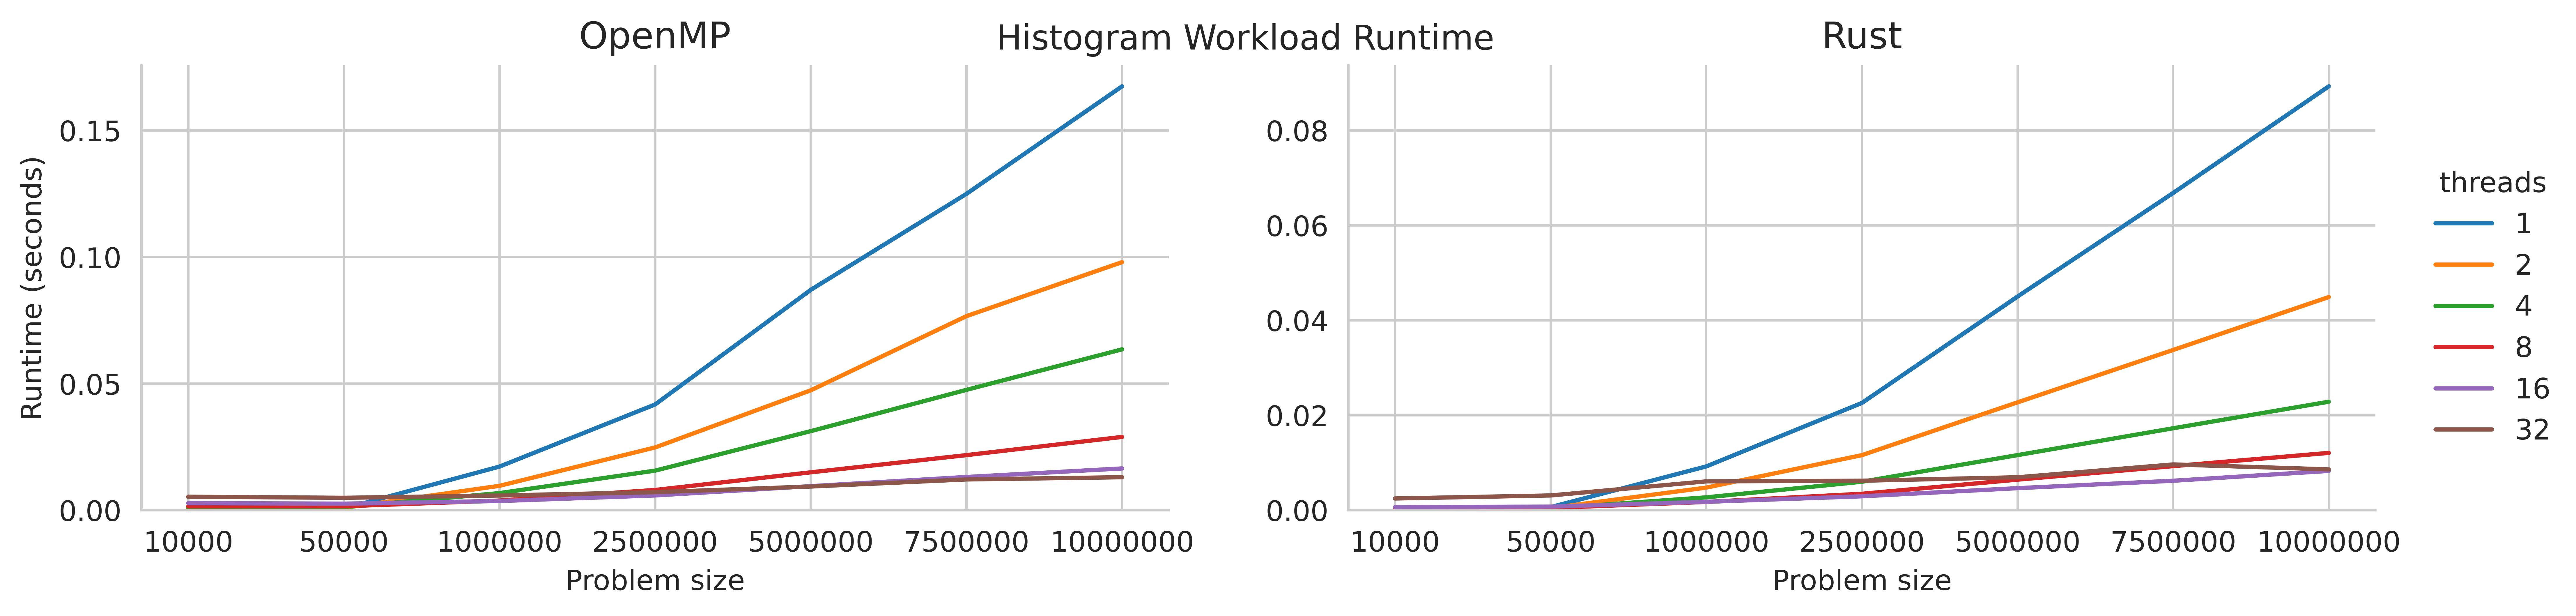

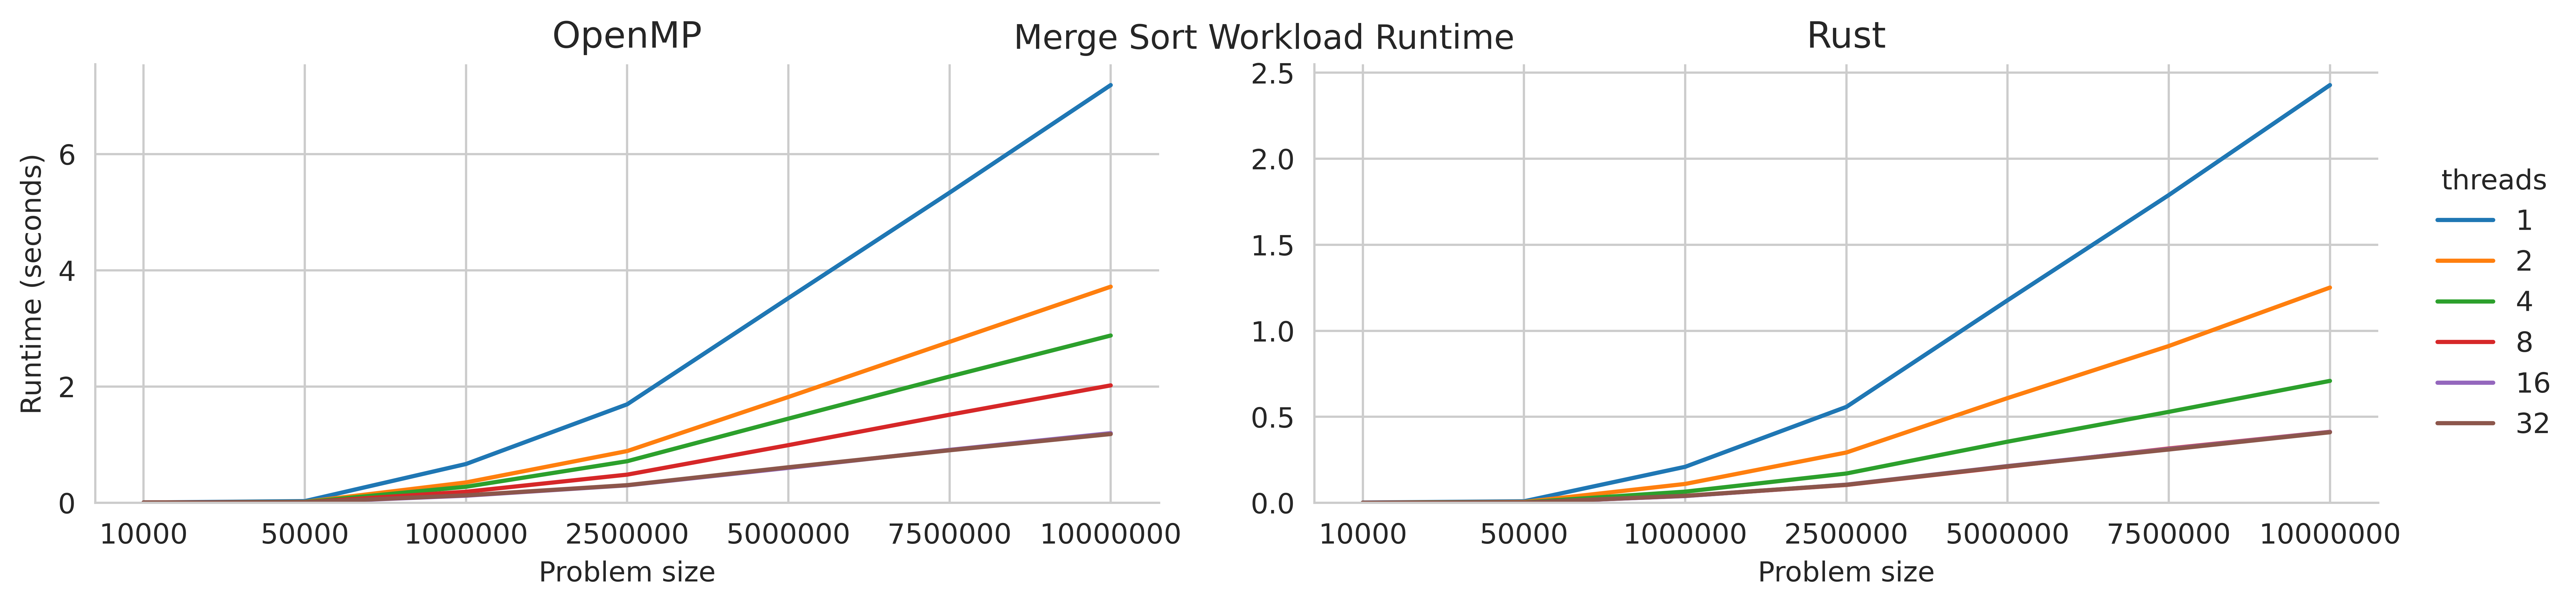

Error in callback <function flush_figures at 0x7f51a672f8b0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [32]:
# Runtime
for b,translated in translate_b.items():
    graph_across(b,lambda x: x["wall_time"],"Runtime (seconds)", f"{translated} Workload Runtime","runtime",simple_construct_df)

In [82]:
# Speedup
for b,translated in translate_b.items():
    graph_across(b,lambda x: x["wall_time"],"Speedup", f"{translated} Speedup","speedup",speedup_construct_df)

In [83]:
# Efficiency
for b,translated in translate_b.items():
    graph_across(b,lambda x: x["wall_time"],"Efficiency(%)", f"{translated} Efficiency","efficiency",eff_construct_df)

In [ ]:
# Runtime overhead
for b,translated in translate_b.items():
    graph_across(b,lambda x: x["runtime_overhead"],"Runtime overhead (seconds)", f"{translated} Runtime Overhead","runtime_overhead",simple_construct_df)

/home/sp6559/multicore/Rust-OpenMP/graphing/lib64/python3.9/site-packages/seaborn/axisgrid.py:453: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


### Summary graphs

In [85]:
# summary compilation time
benchmarks = data.keys()
y_omp = [avg(data[d]["omp_compiletime"]) for d in benchmarks]
y_rust = [avg(data[d]["rust_compiletime"]) for d in benchmarks]

df = pd.DataFrame({"metric_val": [value for pair in zip(y_omp,y_rust) for value in pair] ,
                    "language":["OpenMP","Rust"] * len(data),
                    "benchmark":[translate_b[b] for b in benchmarks for _ in (0, 1)]
                    })

sns.set_style("whitegrid")
plt.rcParams.update({"figure.dpi": 700})
metric_axis_label = "Compilation Time (s)"
sup_title = "Compilation Time for Benchmarks, OpenMP vs. Rust"
g: sns.FacetGrid = sns.catplot(
        data=df, kind="bar",
        x="benchmark", y="metric_val", hue="language",
        palette=sns.color_palette("dark")[0:2], alpha=.6, #height=15 / len(titles) * 2, aspect=len(titles) * 1.46666667 / 2, 
        height = 6,
        # palette=sns.color_palette("dark")[0:3], alpha=.6, height=7, aspect=2.6, col_wrap=1,
    )
g.set_axis_labels("Benchmark", metric_axis_label)
g.legend.set_title("")
g.figure.suptitle(sup_title)
g.figure.set_size_inches(13, 2.66666666)#3.66666666)
ax = g.axes.flat[0]
for c in ax.containers:
    labels = [f'{(v.get_height()):.2f}' for v in c]
    # ax.bar_label(c, labels=labels, label_type='edge')
    ax.bar_label(c, labels=labels, label_type="edge", )
g.figure.tight_layout(rect=[0, 0, 1, 1])
g.legend.set_loc((0.9,0.82))

g.figure.savefig(os.path.join("metric_figs","summary_compilation_times"),bbox_inches="tight")

In [86]:
# summary speedup
df = pd.DataFrame(columns=['metric_val', 'language',"benchmark"])
i = 0

for bench, bench_d in data.items():
    problem_size =benchmark_settings[bench]["default_size"]
    omp_speedup = avg(bench_d["omp_run_stats"]["1"][problem_size]["wall_time"])
    omp_speedup /= avg(bench_d["omp_run_stats"]["8"][problem_size]["wall_time"])

    df.loc[i] = [omp_speedup,"OpenMP",f"{translate_b[bench]}\nn={problem_size}"]
    i += 1
    rust_speedup = avg(bench_d["rust_run_stats"]["1"][problem_size]["wall_time"])
    rust_speedup /= avg(bench_d["rust_run_stats"]["8"][problem_size]["wall_time"])

    df.loc[i] = [rust_speedup,"Rust",f"{translate_b[bench]}\nn={problem_size}"]
    i += 1

sns.set_style("whitegrid")
plt.rcParams.update({"figure.dpi": 700})
metric_axis_label = "Speedup"
sup_title = "Speedup for Benchmarks, OpenMP vs. Rust (8 threads)"
g: sns.FacetGrid = sns.catplot(
        data=df, kind="bar",
        x="benchmark", y="metric_val", hue="language",
        palette=sns.color_palette("dark")[0:2], alpha=.6, #height=15 / len(titles) * 2, aspect=len(titles) * 1.46666667 / 2, 
        height = 6,
        # palette=sns.color_palette("dark")[0:3], alpha=.6, height=7, aspect=2.6, col_wrap=1,
    )
g.set_axis_labels("Benchmark", metric_axis_label)
g.legend.set_title("")
g.figure.suptitle(sup_title)
g.figure.set_size_inches(13, 2.66666666)#3.66666666)
ax = g.axes.flat[0]
for c in ax.containers:
    labels = [f'{(v.get_height()):.2f}' for v in c]
    # ax.bar_label(c, labels=labels, label_type='edge')
    ax.bar_label(c, labels=labels, label_type="edge", )
g.figure.tight_layout(rect=[0, 0, 1, 1])
g.legend.set_loc((0.9,0.82))

g.figure.savefig(os.path.join("metric_figs","summary_speedups"),bbox_inches="tight")

In [87]:
# summary eff
df = pd.DataFrame(columns=['metric_val', 'language',"benchmark"])
i = 0

for bench, bench_d in data.items():
    problem_size =benchmark_settings[bench]["default_size"]
    omp_speedup = avg(bench_d["omp_run_stats"]["1"][problem_size]["wall_time"])
    omp_speedup /= avg(bench_d["omp_run_stats"]["8"][problem_size]["wall_time"])
    omp_eff = omp_speedup/8.00 * 100.00

    df.loc[i] = [omp_eff,"OpenMP",f"{translate_b[bench]}\nn={problem_size}"]
    i += 1
    rust_speedup = avg(bench_d["rust_run_stats"]["1"][problem_size]["wall_time"])
    rust_speedup /= avg(bench_d["rust_run_stats"]["8"][problem_size]["wall_time"])
    rust_eff = rust_speedup/8.00 * 100.00 

    df.loc[i] = [rust_eff,"Rust",f"{translate_b[bench]}\nn={problem_size}"]
    i += 1

sns.set_style("whitegrid")
plt.rcParams.update({"figure.dpi": 700})
metric_axis_label = "Efficiency(%)"
sup_title = "Efficiency for Benchmarks, OpenMP vs. Rust (8 threads)"
g: sns.FacetGrid = sns.catplot(
        data=df, kind="bar",
        x="benchmark", y="metric_val", hue="language",
        palette=sns.color_palette("dark")[0:2], alpha=.6, #height=15 / len(titles) * 2, aspect=len(titles) * 1.46666667 / 2, 
        height = 6,
        # palette=sns.color_palette("dark")[0:3], alpha=.6, height=7, aspect=2.6, col_wrap=1,
    )
g.set_axis_labels("Benchmark", metric_axis_label)
g.legend.set_title("")
g.figure.suptitle(sup_title)
g.figure.set_size_inches(13, 2.66666666)#3.66666666)
ax = g.axes.flat[0]
for c in ax.containers:
    labels = [f'{(v.get_height()):.2f}%' for v in c]
    # ax.bar_label(c, labels=labels, label_type='edge')
    ax.bar_label(c, labels=labels, label_type="edge", )
g.figure.tight_layout(rect=[0, 0, 1, 1])
g.legend.set_loc((0.9,0.82))

g.figure.savefig(os.path.join("metric_figs","summary_efficiencies"),bbox_inches="tight")

In [88]:
# summary overhead
df = pd.DataFrame(columns=['metric_val', 'language',"benchmark"])
i = 0

for bench, bench_d in data.items():
    problem_size =benchmark_settings[bench]["default_size"]
    omp_metric = avg(bench_d["omp_run_stats"]["8"][problem_size]["runtime_overhead"])

    df.loc[i] = [omp_metric,"OpenMP",f"{translate_b[bench]}\nn={problem_size}"]
    i += 1
    rust_metric = avg(bench_d["rust_run_stats"]["8"][problem_size]["runtime_overhead"])

    df.loc[i] = [rust_metric,"Rust",f"{translate_b[bench]}\nn={problem_size}"]
    i += 1

sns.set_style("whitegrid")
plt.rcParams.update({"figure.dpi": 700})
metric_axis_label = "Runtime Overhead(s)"
sup_title = "Runtime Overheads for Benchmarks, OpenMP vs. Rust (8 threads)"
g: sns.FacetGrid = sns.catplot(
        data=df, kind="bar",
        x="benchmark", y="metric_val", hue="language",
        palette=sns.color_palette("dark")[0:2], alpha=.6, #height=15 / len(titles) * 2, aspect=len(titles) * 1.46666667 / 2, 
        height = 6,
        # palette=sns.color_palette("dark")[0:3], alpha=.6, height=7, aspect=2.6, col_wrap=1,
    )
g.set_axis_labels("Benchmark", metric_axis_label)
g.legend.set_title("")
g.figure.suptitle(sup_title)
g.figure.set_size_inches(13, 2.66666666)#3.66666666)
ax = g.axes.flat[0]
for c in ax.containers:
    labels = [f'{(v.get_height()):.2f}' for v in c]
    # ax.bar_label(c, labels=labels, label_type='edge')
    ax.bar_label(c, labels=labels, label_type="edge", )
g.figure.tight_layout(rect=[0, 0, 1, 1])
g.legend.set_loc((0.9,0.82))

g.figure.savefig(os.path.join("metric_figs","summary_overheads"),bbox_inches="tight")

In [89]:
# summary cycles vs l1
df = pd.DataFrame(columns=['metric_val','type', 'language',"benchmark"])
i = 0

for bench, bench_d in data.items():
    problem_size =benchmark_settings[bench]["default_size"]
    try:
        omp_cycles = avg(bench_d["omp_run_stats"]["8"][problem_size]["cycles_ghz"])
        omp_loads = avg(bench_d["omp_run_stats"]["8"][problem_size]["l1_load_per_sec"])

        df.loc[i] = [omp_cycles,"Cycles","OpenMP",f"{translate_b[bench]}\nn={problem_size}"]
        i += 1
        df.loc[i] = [omp_loads,"L1 Loads/sec","OpenMP",f"{translate_b[bench]}\nn={problem_size}"]
        i += 1
        rust_cycles = avg(bench_d["rust_run_stats"]["8"][problem_size]["cycles_ghz"])
        rust_loads = avg(bench_d["rust_run_stats"]["8"][problem_size]["l1_load_per_sec"])

        df.loc[i] = [rust_cycles,"Cycles","Rust",f"{translate_b[bench]}\nn={problem_size}"]
        i += 1
        df.loc[i] = [rust_loads,"L1 Loads/sec","Rust",f"{translate_b[bench]}\nn={problem_size}"]
        i += 1
    except KeyError:
        continue

sns.set_style("whitegrid")
plt.rcParams.update({"figure.dpi": 700})
metric_axis_label = "GHz (plot 1)/Loads per sec (plot 2)"
sup_title = "CPU Cycles/Sec (GHz) vs. L1 Cache Loads/Sec, OpenMP vs. Rust (8 threads)"
g: sns.FacetGrid = sns.catplot(
        data=df, kind="bar",
        x="benchmark", y="metric_val", hue="language", col='type',
        palette=sns.color_palette("dark")[0:2], alpha=.6, #height=15 / len(titles) * 2, aspect=len(titles) * 1.46666667 / 2, 
        height = 6,sharey=False,
        # palette=sns.color_palette("dark")[0:3], alpha=.6, height=7, aspect=2.6, col_wrap=1,
    )
g.set_axis_labels("Benchmark", metric_axis_label)
g.legend.set_title("")
g.figure.suptitle(sup_title)
g.figure.set_size_inches(13, 2.66666666)#3.66666666)

g.axes.flat[0].set_title("CPU Cycles/Sec (GHz)")#,fontsize=13)
g.axes.flat[1].set_title("L1 Loads/Sec")#,fontsize=13)

# ax = g.axes.flat[0]
for ax in g.axes.flat:
    for c in ax.containers:
        labels = [f'{(v.get_height()):.2f}' for v in c]
        if c[0].get_height() > 100000:
            labels = [f'{(v.get_height()):.0e}' for v in c]
        # ax.bar_label(c, labels=labels, label_type='edge')
        ax.bar_label(c, labels=labels, label_type="edge", )
        
g.figure.tight_layout(rect=[0, 0, 1, 1])
g.legend.set_loc((0.9,0.82))

g.figure.savefig(os.path.join("metric_figs","summary_cycles_vs_l1"),bbox_inches="tight")

In [90]:
# summary cycles vs l1
df = pd.DataFrame(columns=['metric_val','type', 'language',"benchmark"])
i = 0

for bench, bench_d in data.items():
    problem_size =benchmark_settings[bench]["default_size"]
    try:
        omp_cycles = avg(bench_d["omp_run_stats"]["8"][problem_size]["cycles_ghz"])
        omp_loads = avg(bench_d["omp_run_stats"]["8"][problem_size]["l1_load_per_sec"])

        df.loc[i] = [omp_cycles,"Cycles","OpenMP",f"{translate_b[bench]}\nn={problem_size}"]
        i += 1
        df.loc[i] = [omp_loads,"L1 Loads/sec","OpenMP",f"{translate_b[bench]}\nn={problem_size}"]
        i += 1
        rust_cycles = avg(bench_d["rust_run_stats"]["8"][problem_size]["cycles_ghz"])
        rust_loads = avg(bench_d["rust_run_stats"]["8"][problem_size]["l1_load_per_sec"])

        df.loc[i] = [rust_cycles,"Cycles","Rust",f"{translate_b[bench]}\nn={problem_size}"]
        i += 1
        df.loc[i] = [rust_loads,"L1 Loads/sec","Rust",f"{translate_b[bench]}\nn={problem_size}"]
        i += 1
    except KeyError:
        continue

sns.set_style("whitegrid")
plt.rcParams.update({"figure.dpi": 700})
metric_axis_label = "GHz (plot 1)/Loads per sec (plot 2)"
sup_title = "CPU Cycles/Sec (GHz) vs. L1 Cache Loads/Sec, OpenMP vs. Rust (8 threads)"
g: sns.FacetGrid = sns.catplot(
        data=df, kind="bar",
        x="benchmark", y="metric_val", hue="language", col='type',
        palette=sns.color_palette("dark")[0:2], alpha=.6, #height=15 / len(titles) * 2, aspect=len(titles) * 1.46666667 / 2, 
        height = 6,sharey=False,
        # palette=sns.color_palette("dark")[0:3], alpha=.6, height=7, aspect=2.6, col_wrap=1,
    )
g.set_axis_labels("Benchmark", metric_axis_label)
g.legend.set_title("")
g.figure.suptitle(sup_title)
g.figure.set_size_inches(13, 2.66666666)#3.66666666)

g.axes.flat[0].set_title("CPU Cycles/Sec (GHz)")#,fontsize=13)
g.axes.flat[1].set_title("L1 Loads/Sec")#,fontsize=13)

# ax = g.axes.flat[0]
for ax in g.axes.flat:
    for c in ax.containers:
        labels = [f'{(v.get_height()):.2f}' for v in c]
        if c[0].get_height() > 100000:
            labels = [f'{(v.get_height()):.0e}' for v in c]
        # ax.bar_label(c, labels=labels, label_type='edge')
        ax.bar_label(c, labels=labels, label_type="edge", )
        
g.figure.tight_layout(rect=[0, 0, 1, 1])
g.legend.set_loc((0.9,0.82))

g.figure.savefig(os.path.join("metric_figs","summary_cycles_vs_l1"),bbox_inches="tight")

In [91]:
# summary scatter plot cycles vs L1 load
# summary cycles vs l1
df = pd.DataFrame(columns=['cycles','loads','language',"benchmark"])
i = 0

for bench, bench_d in data.items():
    problem_size =benchmark_settings[bench]["default_size"]
    # try:
    omp_cycles = avg(bench_d["omp_run_stats"]["8"][problem_size]["cycles_ghz"])
    omp_loads = avg(bench_d["omp_run_stats"]["8"][problem_size]["l1_load_per_sec"])

    df.loc[i] = [omp_cycles,omp_loads,"OpenMP",f"{translate_b[bench]}\nn={problem_size}"]
    i += 1
    rust_cycles = avg(bench_d["rust_run_stats"]["8"][problem_size]["cycles_ghz"])
    rust_loads = avg(bench_d["rust_run_stats"]["8"][problem_size]["l1_load_per_sec"])

    df.loc[i] = [rust_cycles,rust_loads,"Rust",f"{translate_b[bench]}\nn={problem_size}"]
    i += 1
    # except KeyError:
    #     continue

sns.set_style("whitegrid")
plt.rcParams.update({"figure.dpi": 700})
metric_axis_label = "Cache Loads per sec"
sup_title = "CPU Cycles/Sec (GHz) vs. L1 Cache Loads/Sec by Benchmark, OpenMP vs. Rust (8 threads)"
g: sns.FacetGrid = sns.relplot(df,x = "cycles",y="loads", col="language", hue="benchmark",
               facet_kws={'sharey': False, 'sharex': False},s=75)

for ax in g.axes.flat:
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)

# g.set(yscale="log")
g.set_axis_labels("CPU Cycles/Sec (GHz)", metric_axis_label)
g.legend.set_title("Benchmarks")
sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(.4, 1), ncol=6, title=None, frameon=False,
)
g.figure.suptitle(sup_title,y=1.01)
g.figure.set_size_inches(13, 5)#3.66666666)

g.axes.flat[0].set_title("OpenMP")#,fontsize=13)
g.axes.flat[1].set_title("Rust")#,fontsize=13)

for ax in g.axes.flat:
    ax.plot([0, 1], [0, 1], transform=ax.transAxes,color='grey', ls='--')
# ax = g.axes.flat[0]
# for ax in g.axes.flat:
#     for c in ax.containers:
#         labels = [f'{(v.get_height()):.2f}' for v in c]
#         if c[0].get_height() > 100000:
#             labels = [f'{(v.get_height()):.0e}' for v in c]
#         # ax.bar_label(c, labels=labels, label_type='edge')
#         ax.bar_label(c, labels=labels, label_type="edge", )
        
# g.figure.tight_layout(rect=[0, 0, 1.1, 1.1])
# g.legend.set_loc((0.88,0.7))

g.figure.savefig(os.path.join("metric_figs","summary_cycles_vs_l1_line"),bbox_inches="tight")

In [92]:
plt.ion()

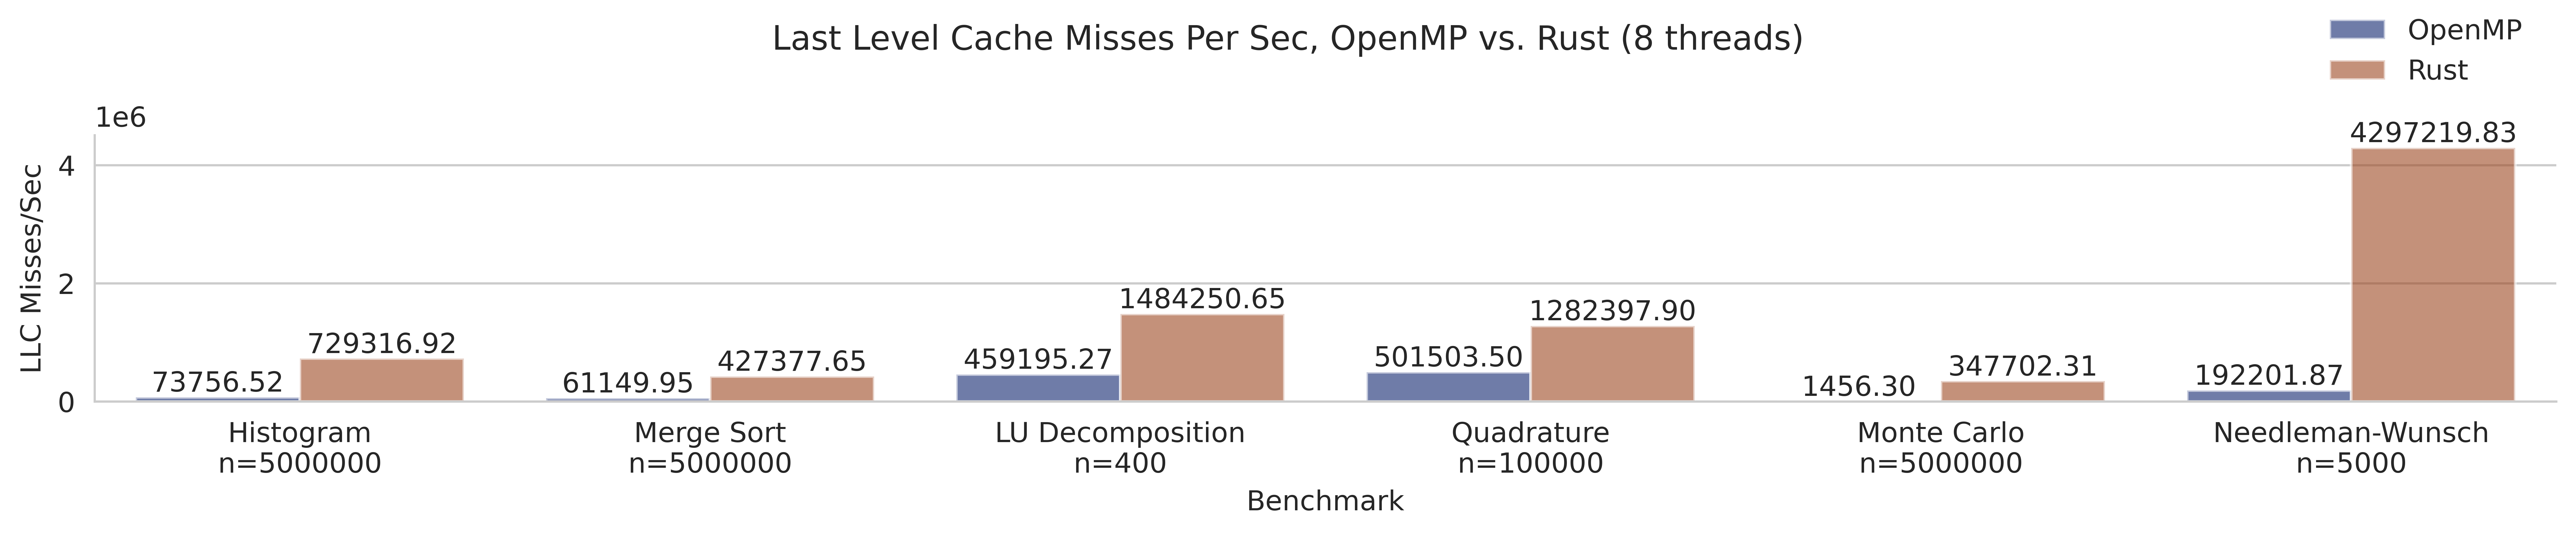

In [6]:
# summary total LLC misses
df = pd.DataFrame(columns=['metric_val', 'language',"benchmark"])
i = 0

for bench, bench_d in data.items():
    problem_size =benchmark_settings[bench]["default_size"]
    omp_metric = avg(bench_d["omp_run_stats"]["8"][problem_size]["last_l_load_per_sec"])
    omp_metric *= avg(bench_d["omp_run_stats"]["8"][problem_size]["ll_miss_percent"]) / 100

    df.loc[i] = [omp_metric,"OpenMP",f"{translate_b[bench]}\nn={problem_size}"]
    i += 1
    rust_metric = avg(bench_d["rust_run_stats"]["8"][problem_size]["last_l_load_per_sec"])
    rust_metric *= avg(bench_d["rust_run_stats"]["8"][problem_size]["ll_miss_percent"]) / 100 
    df.loc[i] = [rust_metric,"Rust",f"{translate_b[bench]}\nn={problem_size}"]
    
    i += 1

sns.set_style("whitegrid")
plt.rcParams.update({"figure.dpi": 700})
metric_axis_label = "LLC Misses/Sec"
sup_title = "Last Level Cache Misses Per Sec, OpenMP vs. Rust (8 threads)"
g: sns.FacetGrid = sns.catplot(
        data=df, kind="bar",
        x="benchmark", y="metric_val", hue="language",
        palette=sns.color_palette("dark")[0:2], alpha=.6, #height=15 / len(titles) * 2, aspect=len(titles) * 1.46666667 / 2, 
        height = 6,
        # palette=sns.color_palette("dark")[0:3], alpha=.6, height=7, aspect=2.6, col_wrap=1,
    )
g.set_axis_labels("Benchmark", metric_axis_label)
g.legend.set_title("")
g.figure.suptitle(sup_title)
g.figure.set_size_inches(13, 2.66666666)#3.66666666)
ax = g.axes.flat[0]
for c in ax.containers:
    labels = [f'{(v.get_height()):.2f}' for v in c]
    # ax.bar_label(c, labels=labels, label_type='edge')
    ax.bar_label(c, labels=labels, label_type="edge", )
g.figure.tight_layout(rect=[0, 0, 1, 1])
g.legend.set_loc((0.9,0.82))

g.figure.savefig(os.path.join("metric_figs","summary_llc_misses"),bbox_inches="tight")